# Importing libraries

In [1]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from bertopic import BERTopic
from bertopic.representation import TextGeneration
from git_root import git_root
from hdbscan import HDBSCAN
from nltk.corpus import stopwords
from rdflib import Graph, Literal, RDF, Namespace
from rdflib.namespace import XSD
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_distances
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import BitsAndBytesConfig
from umap import UMAP

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
my_git_root = git_root()
sys.path.append(my_git_root)
from src import *

# Loading the data

In [2]:
df_documents_path = f'{my_git_root}/final_notebooks/data/chunked_documents_final.csv'
df_documents = pd.read_csv(df_documents_path)

In [3]:
df_documents

,name,text
0,aalto-university.md,Aalto University
1,aalto-university.md,Aalto University Research Data Management Policy
2,aalto-university.md,The research data management policy aims to ma...
3,aalto-university.md,The data management policy shall be implemente...
4,aalto-university.md,Ownership of copyright protected research data...
...,...,...
3481,wrexham-university.md,"FAIR Data\n\nWhere it is lawful to do so, the ..."
3482,wrexham-university.md,Prifysgol Wrecsam Wrexham University\n\nPublic...
3483,wrexham-university.md,Reporting a Data Incident/Breach\n\nThe UK GDP...
3484,wrexham-university.md,"Other Polices, Procedures, Legislation\n\nThis..."


In [4]:
documents = df_documents['text'].to_list()

# Topic Modelling

In [5]:
embedding_model = SentenceTransformer('thenlper/gte-small', trust_remote_code=True)

embeddings = embedding_model.encode(documents)

Insert parameters from optimized harmonic mean

In [6]:
umap_parameters = {
    'n_neighbors': 61,
    'n_components': 5,
    'min_dist': 0.4380765366409879,
    'metric': 'cosine',
    'random_state': 42
}

umap_model = UMAP(**umap_parameters)

hdbscan_parameters = {
    'min_cluster_size': 12,
    'min_samples': 8,
}

hdbscan_model = HDBSCAN(**hdbscan_parameters)

bertopic_parameters = {
    'top_n_words': 25,
    'n_gram_range': (2, 5),
    'umap_model': umap_model,
    'hdbscan_model': hdbscan_model
}

In [7]:
bertopic_parameters = {
    'top_n_words': 25,
    'n_gram_range': (2, 4),
    'umap_model': umap_model,
    'hdbscan_model': hdbscan_model,
    'verbose': True
}

In [8]:
topic_model = BERTopic(**bertopic_parameters)
topics, probs = topic_model.fit_transform(documents, embeddings)

2025-02-08 11:38:20,279 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-08 11:38:36,733 - BERTopic - Dimensionality - Completed ✓
2025-02-08 11:38:36,734 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-08 11:38:36,798 - BERTopic - Cluster - Completed ✓
2025-02-08 11:38:36,800 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-08 11:38:38,010 - BERTopic - Representation - Completed ✓


In [9]:
df_document_info = topic_model.get_document_info(documents)

In [10]:
df_document_info['Document_Name'] = df_documents['name']

# Displaying the number of chunks per topic

In [11]:
topic_counts = df_document_info['Topic'].value_counts()

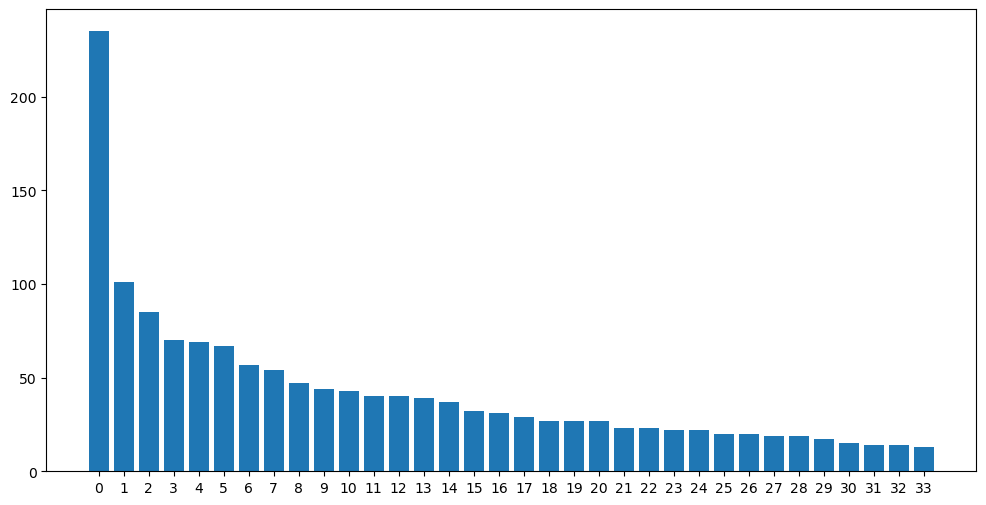

In [12]:
topic_indices = np.arange(0, len(topic_counts) - 1, 1)
topic_counts_graph = [topic_counts[i] for i in topic_indices]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x=topic_indices, height=topic_counts_graph)
ax.set_xticks(topic_indices)
plt.savefig(f'{my_git_root}/final_notebooks/images/optimized_models/bertopic_harmonic_mean_topic_counts.svg')
plt.show()

In [13]:
topic_counts

Topic
-1     2044
 0      235
 1      101
 2       85
 3       70
 4       69
 5       67
 6       57
 7       54
 8       47
 9       44
 10      43
 11      40
 12      40
 13      39
 14      37
 15      32
 16      31
 17      29
 18      27
 19      27
 20      27
 21      23
 22      23
 23      22
 24      22
 25      20
 26      20
 27      19
 28      19
 29      17
 30      15
 31      14
 32      14
 33      13
Name: count, dtype: int64

In [14]:
np.mean(topic_counts[1:])

42.411764705882355

In [15]:
np.std(topic_counts[1:])

39.67820386045335

# Updating topic names to be more human-readable

Setting up LLM for topic interpretation

In [16]:
use_4bit = False
use_8bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    load_in_8bit=use_8bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

In [17]:
torch.random.manual_seed(0)
model_id = "tiiuae/Falcon3-7B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda",
    torch_dtype="auto",
    quantization_config=bnb_config,
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=50,
    repetition_penalty=1.1
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda


In [18]:
prompt = """<|system|>You are a helpful, respectful and honest assistant for labeling topics for texts extracted from Research Data Management Policies.</s>
<|user|>
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.</s>
<|assistant|>"""


In [19]:
# Text generation with Zephyr
llm = TextGeneration(pipe, prompt=prompt)
representation_model = {"representation_LLM": llm}

In [20]:
topic_model.update_topics(documents, top_n_words=1000, n_gram_range=(2, 5), representation_model=representation_model)

2025-02-08 11:38:54,526 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
100%|██████████| 35/35 [02:15<00:00,  3.87s/it]


In [21]:
df_topic_info = topic_model.get_topic_info()

In [22]:
topics_full = topic_model.get_topics()

Load the topic descriptors into an array

In [23]:
interpretable_topic_names = {}

for index, value in topics_full.items():
    interpretable_topic_name = [topic_descriptor for topic_descriptor, probability in value]
    interpretable_topic_names[index] = interpretable_topic_name

Remove stop-words and only show top 25 descriptors

In [24]:
def remove_stop_words(text):
    stop_words = stopwords.words('english')
    regex_stop_words = '|'.join(stop_words)
    result = re.sub(rf'^((?:{regex_stop_words})\s+)+', '', text)
    result = re.sub(rf'(\s+(?:{regex_stop_words}))+$', '', result)
    return result

In [25]:
def remove_single_words(topic_descriptors):
    result = []
    for topic_descriptor in topic_descriptors:
        if bool(re.search('\s+', topic_descriptor)):
            result.append(topic_descriptor)
    return result

In [26]:
def remove_duplicate_words(topic_descriptors):
    result = []

    for topic_descriptor in topic_descriptors:
        if topic_descriptor not in result:
            result.append(topic_descriptor)
    return result

In [27]:
def keep_top_n_topic_descriptors(topic_descriptors, n):
    return topic_descriptors[:n]

In [28]:
n = 25

for index, value in interpretable_topic_names.items():
    interpretable_topics = [remove_stop_words(topic) for topic in value]
    interpretable_topics = remove_single_words(interpretable_topics)
    interpretable_topics = remove_duplicate_words(interpretable_topics)
    interpretable_topics = keep_top_n_topic_descriptors(interpretable_topics, n)
    interpretable_topic_names[index] = interpretable_topics

In [29]:
for key, value in interpretable_topic_names.items():
    if key != -1:
        assert len(value) == 25, f'Topic {key} has {len(value)} topics, rather than {n}.'

In [30]:
df_topic_info = topic_model.get_topic_info()

In [31]:
for key, value in interpretable_topic_names.items():
    topic_id = key
    ctfidf_representation = value
    llm_representation = df_topic_info.iloc[index + 1]['representation_LLM']

    print(f'\\textbf{{Topic {topic_id}}}:\n\n\\noindent\\textbf{{cTF-IDF representation: }}{", ".join(ctfidf_representation)}\n\n\\noindent\\textbf{{LLM representation: }}{llm_representation[0]}\\\\\n\n\\noindent')

\textbf{Topic -1}:

\noindent\textbf{cTF-IDF representation: }research data, data management, research data management, personal data, data protection, research project, data must, management plan, data management plan, open access, intellectual property, research projects, research data must, management policy, data sharing, data management policy, made available, management plans, management of research data, management of research, data management plans, third parties, data repository, open research, data policy

\noindent\textbf{LLM representation: }
"General Principles and Guidelines in Research Data Management Policies"\\

\noindent
\textbf{Topic 0}:

\noindent\textbf{cTF-IDF representation: }data management, research data, research data management, research project, responsible for ensuring, principal investigator, principal investigators, phd students, responsibility for research, data management plan, management plan, data steward, responsibility for research data, roles and r

# Exploring the topics

In [32]:
df_document_info

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,Document_Name
0,Aalto University,-1,-1_research data_of the_data management_the data,"[research data, of the, data management, the d...",[4. Research Data Management \n\nResearch dat...,research data - of the - data management - the...,0.0,False,aalto-university.md
1,Aalto University Research Data Management Policy,-1,-1_research data_of the_data management_the data,"[research data, of the, data management, the d...",[4. Research Data Management \n\nResearch dat...,research data - of the - data management - the...,0.0,False,aalto-university.md
2,The research data management policy aims to ma...,-1,-1_research data_of the_data management_the data,"[research data, of the, data management, the d...",[4. Research Data Management \n\nResearch dat...,research data - of the - data management - the...,0.0,False,aalto-university.md
3,The data management policy shall be implemente...,-1,-1_research data_of the_data management_the data,"[research data, of the, data management, the d...",[4. Research Data Management \n\nResearch dat...,research data - of the - data management - the...,0.0,False,aalto-university.md
4,Ownership of copyright protected research data...,-1,-1_research data_of the_data management_the data,"[research data, of the, data management, the d...",[4. Research Data Management \n\nResearch dat...,research data - of the - data management - the...,0.0,False,aalto-university.md
...,...,...,...,...,...,...,...,...,...
3481,"FAIR Data\n\nWhere it is lawful to do so, the ...",-1,-1_research data_of the_data management_the data,"[research data, of the, data management, the d...",[4. Research Data Management \n\nResearch dat...,research data - of the - data management - the...,0.0,False,wrexham-university.md
3482,Prifysgol Wrecsam Wrexham University\n\nPublic...,-1,-1_research data_of the_data management_the data,"[research data, of the, data management, the d...",[4. Research Data Management \n\nResearch dat...,research data - of the - data management - the...,0.0,False,wrexham-university.md
3483,Reporting a Data Incident/Breach\n\nThe UK GDP...,-1,-1_research data_of the_data management_the data,"[research data, of the, data management, the d...",[4. Research Data Management \n\nResearch dat...,research data - of the - data management - the...,0.0,False,wrexham-university.md
3484,"Other Polices, Procedures, Legislation\n\nThis...",-1,-1_research data_of the_data management_the data,"[research data, of the, data management, the d...",[4. Research Data Management \n\nResearch dat...,research data - of the - data management - the...,0.0,False,wrexham-university.md


In [33]:
def get_topic_info(df_document_info, df_topic_info, topic_names):
    for index, topic_name in topic_names.items():
        my_df_document_info = df_document_info[df_document_info['Topic'] == index]
        print(f'Topic: {index}\n')
        print(f'Representation: {", ".join(topic_name)}\n')
        print(f'representation_LLM: {df_topic_info.iloc[index + 1]["representation_LLM"][0]}\n')
        print(f'Chunks:')
        for doc in my_df_document_info['Document'].to_list():
            print(f'\t{doc}\n')
            print('_'*50)

Uncomment this to see how topics were represented for expert evaluation

In [34]:
# get_topic_info(df_document_info, df_topic_info, interpretable_topic_names)

In [35]:
df_document_info.to_csv(f'{my_git_root}/final_notebooks/optimized_models/outputs/bertopic_harmonic_mean_document_info.csv', index=False)

In [36]:
mask = df_document_info['Document_Name'] != -1
len(df_document_info[mask]['Document_Name'].unique())

142

# Make Knowledge Graph

In [37]:
# Define namespaces
PT = Namespace("http://policy-topics.org/")
SCHEMA = Namespace("http://schema.org/")

# Create a new graph
graph = Graph()

graph.bind("pt", PT)

Default topic embeddings are represented by the centroid of their respective topic. Instead, we will use the text embeddings of the topic descriptor.

In [38]:
topic_embeddings = []

for key, value in interpretable_topic_names.items():
    topic_descriptor_joined = ', '.join(value)
    topic_embedding = embedding_model.encode(topic_descriptor_joined)
    topic_embeddings.append(topic_embedding)

In [39]:
# Compute pairwise cosine distances
distance_matrix = cosine_distances(topic_embeddings)

# Create a DataFrame to store closest neighbors
closest_vectors = []

for i in range(len(topic_embeddings)):
    # Get indices of the three closest vectors (excluding itself)
    closest_indices = np.argsort(distance_matrix[i])[1:4]  # Skip first (self)
    closest_vectors.append(closest_indices)

topic_indices = np.arange(-1, len(topic_embeddings) - 1, 1)

# Convert to DataFrame
df_topic_distances = pd.DataFrame(closest_vectors, columns=["Closest_1", "Closest_2", "Closest_3"])
df_topic_distances['topic_index'] = topic_indices

In [40]:
df_document_info['name'] = df_documents['name']

In [41]:
for document_index, name in enumerate(df_document_info['name'].unique()):
    document_uri = PT[f"Document_{document_index}"]
    my_name = re.sub(r'.md', '', name)

    graph.add((document_uri, RDF['type'], SCHEMA['document']))
    graph.add((document_uri, SCHEMA['title'], Literal(my_name, datatype=XSD.string)))

    df_this_document = df_document_info[df_document_info['name'] == name].reset_index()

    for topic_index in df_this_document['Topic'].unique():
        topic_uri = PT[f'Topic_{topic_index}']
        graph.add((topic_uri, RDF['type'], SCHEMA['topic']))
        topic_descriptors = interpretable_topic_names[topic_index]
        topic_descriptors = ', '.join(topic_descriptors)
        graph.add((topic_uri, PT['topic_descriptors'], Literal(topic_descriptors, datatype=XSD.string)))

    for chunk_index, row in df_this_document.iterrows():
        chunk_uri = PT[f"Chunk_{document_index}_{chunk_index}"]
        graph.add((chunk_uri, RDF['type'], SCHEMA['chunk']))
        graph.add((chunk_uri, SCHEMA['text'], Literal(row['Document'], datatype=XSD.string)))
        graph.add((document_uri, PT['has'], chunk_uri))
        chunk_topic_uri = PT[f'Topic_{row["Topic"]}']
        graph.add((chunk_uri, PT['describes'], chunk_topic_uri))

for index, row in df_topic_distances.iterrows():
    from_topic = PT[f'Topic_{row["topic_index"]}']
    for i in range(1, 4):
        to_topic = PT[f'Topic_{row[f"Closest_{i}"]}']
        graph.add((from_topic, PT[f'closest_{i}'], to_topic))

In [42]:
graph.serialize(destination=f'{my_git_root}/final_notebooks/knowledge_graph/topic_modelling_test.ttl', format='turtle')

<Graph identifier=Neefe8019d6ab45a99d8140c8ef6313dc (<class 'rdflib.graph.Graph'>)>

# Exporting Data for RAG

In [43]:
topic_embeddings_dict = {}

index = -1

for topic_embedding in topic_embeddings:
    topic_embeddings_dict[index] = topic_embedding
    index += 1

In [44]:
def store_file(file, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(file, f)

In [45]:
store_file(topic_embeddings_dict, f'{my_git_root}/rag_docs/topic_embeddings.pkl')

In [46]:
df_documents['topic'] = df_document_info['Topic']

In [47]:
df_documents.to_csv(f'{my_git_root}/rag_docs/topic_documents.csv', index=False)